In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from google.colab import files
from torch.optim.optimizer import Optimizer
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomResizedCrop(224), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(),
                                      normalize])
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])

In [19]:
batch_size = 100
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [20]:
import time

def timeSince(since):
    now = time.time()
    s = now - since
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)

In [21]:
def evaluateImageModel(model, data, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for image, labels in data:
            image, labels = image.to(device), labels.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum().item()
            total += len(labels)
            loss = criterion(output, labels)
            total_loss += loss.item()

    return total_loss / len(data), 1 - correct / total

In [22]:
def trainImageModel(model, train_data, val_data, n_epochs, criterion, optimizer, device, path):
    model.train()
    train_error_list = []
    val_error_list = []
    min_error = None
    step = 0
    print_every = len(train_data)
    start = time.time()
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for image, labels in train_data:
            optimizer.zero_grad()
            step += 1
            image, labels = image.to(device), labels.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)
            running_correct += (pred == labels).sum().item()
            running_total += len(labels)
            loss = criterion(output, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            if step % print_every == 0:
                val_loss, val_error = evaluateImageModel(model, val_data, criterion, device)
                print(('%d/%d (%s) train loss: %.3f, train error: %.2f%%, val loss: %.3f, val error: %.2f%%') %
                      (epoch + 1, n_epochs, timeSince(start), running_loss / len(train_data), 
                       100 *(1 - running_correct / running_total), val_loss, 100 * val_error))
                train_error_list.append(1 - running_correct / running_total)
                val_error_list.append(val_error)
                if min_error is None or min_error > val_error:
                    if min_error is None:
                        print(('Validation error rate in first epoch: %.2f%%') % (100 * val_error))
                    else:
                        print(('Validation error rate is decreasing: %.2f%% --> %.2f%%') % 
                              (100 * min_error, 100 * val_error))
                    min_error = val_error
                    print('Saving model...')
                    torch.save(model, path)
                
                model.train()
                running_loss = 0.0
                running_correct = 0
                running_total = 0
    
    return train_error_list, val_error_list

In [ ]:
import torch.optim as optim

train_list = None
test_list = None
model = models.resnet34()
optimizer = optim.Adam(model.parameters())
model.to(device)
n_epochs = 100
criterion = nn.CrossEntropyLoss()
path = 'AdamRes.pt'
train_list, test_list = trainImageModel(model, trainloader, testloader, n_epochs, criterion, optimizer, device, path)
torch.save(train_list, 'adamres_train.pt')
torch.save(test_list, 'adamres_test.pt')
files.download('adamres_train.pt')
files.download('adamres_test.pt')

1/100 (1m 43s) train loss: 1.849, train error: 67.61%, val loss: 1.443, val error: 51.75%
Validation error rate in first epoch: 51.75%
Saving model...
2/100 (3m 28s) train loss: 1.473, train error: 53.25%, val loss: 1.280, val error: 45.84%
Validation error rate is decreasing: 51.75% --> 45.84%
Saving model...
3/100 (5m 11s) train loss: 1.253, train error: 44.86%, val loss: 1.059, val error: 37.16%
Validation error rate is decreasing: 45.84% --> 37.16%
Saving model...
4/100 (6m 54s) train loss: 1.109, train error: 39.52%, val loss: 0.839, val error: 28.87%
Validation error rate is decreasing: 37.16% --> 28.87%
Saving model...
5/100 (8m 38s) train loss: 1.007, train error: 35.51%, val loss: 0.834, val error: 28.44%
Validation error rate is decreasing: 28.87% --> 28.44%
Saving model...
6/100 (10m 20s) train loss: 0.953, train error: 33.24%, val loss: 0.688, val error: 23.65%
Validation error rate is decreasing: 28.44% --> 23.65%
Saving model...
7/100 (12m 1s) train loss: 0.879, train err

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 100
criterion = nn.CrossEntropyLoss()
train_list = None
test_list = None
model = models.shufflenet_v2_x1_0()
optimizer = optim.Adam(model.parameters())
model.to(device)
path = 'adamshuffle.pt'
train_list, test_list = trainImageModel(model, trainloader, testloader, n_epochs, criterion, optimizer, device, path)
torch.save(train_list, 'adamshuffle_train.pt')
torch.save(test_list, 'adamshuffle_test.pt')
files.download('adamshuffle_train.pt')
files.download('adamshuffle_test.pt')

1/100 (1m 49s) train loss: 1.796, train error: 65.33%, val loss: 1.379, val error: 51.17%
Validation error rate in first epoch: 51.17%
Saving model...
2/100 (3m 35s) train loss: 1.445, train error: 51.97%, val loss: 1.217, val error: 43.48%
Validation error rate is decreasing: 51.17% --> 43.48%
Saving model...
3/100 (5m 24s) train loss: 1.263, train error: 45.12%, val loss: 0.974, val error: 34.88%
Validation error rate is decreasing: 43.48% --> 34.88%
Saving model...
4/100 (7m 13s) train loss: 1.131, train error: 40.15%, val loss: 0.793, val error: 27.73%
Validation error rate is decreasing: 34.88% --> 27.73%
Saving model...
5/100 (9m 3s) train loss: 1.038, train error: 36.52%, val loss: 0.793, val error: 27.23%
Validation error rate is decreasing: 27.73% --> 27.23%
Saving model...
6/100 (10m 51s) train loss: 0.972, train error: 33.97%, val loss: 0.741, val error: 25.14%
Validation error rate is decreasing: 27.23% --> 25.14%
Saving model...
7/100 (12m 41s) train loss: 0.914, train err

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 100
criterion = nn.CrossEntropyLoss()
train_list = None
test_list = None
model = models.mobilenet_v2()
optimizer = optim.Adam(model.parameters())
model.to(device)
name = 'adammobile'
path = name + '.pt'
train_list, test_list = trainImageModel(model, trainloader, testloader, n_epochs, criterion, optimizer, device, path)
torch.save(train_list, name + '_train.pt')
torch.save(test_list, name + '_test.pt')
files.download(name + '_train.pt')
files.download(name + '_test.pt')

1/100 (1m 56s) train loss: 1.734, train error: 63.16%, val loss: 1.372, val error: 49.73%
Validation error rate in first epoch: 49.73%
Saving model...
2/100 (3m 54s) train loss: 1.412, train error: 50.72%, val loss: 1.125, val error: 39.88%
Validation error rate is decreasing: 49.73% --> 39.88%
Saving model...
3/100 (5m 49s) train loss: 1.241, train error: 44.22%, val loss: 1.018, val error: 34.68%
Validation error rate is decreasing: 39.88% --> 34.68%
Saving model...
4/100 (7m 48s) train loss: 1.118, train error: 39.58%, val loss: 0.765, val error: 26.30%
Validation error rate is decreasing: 34.68% --> 26.30%
Saving model...
5/100 (9m 41s) train loss: 1.028, train error: 36.36%, val loss: 0.700, val error: 23.62%
Validation error rate is decreasing: 26.30% --> 23.62%
Saving model...
6/100 (11m 33s) train loss: 0.964, train error: 33.71%, val loss: 0.641, val error: 22.35%
Validation error rate is decreasing: 23.62% --> 22.35%
Saving model...
7/100 (13m 26s) train loss: 0.914, train er

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

Mon Dec 14 05:58:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    37W / 300W |  15873MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lsof /dev/nvidia*

COMMAND  PID USER   FD   TYPE  DEVICE SIZE/OFF  NODE NAME
python3 8425 root  mem    CHR 195,255          18806 /dev/nvidiactl
python3 8425 root  mem    CHR   195,0          18805 /dev/nvidia0
python3 8425 root  mem    CHR   246,0          18803 /dev/nvidia-uvm
python3 8425 root   59u   CHR 195,255      0t0 18806 /dev/nvidiactl
python3 8425 root   60u   CHR   246,0      0t0 18803 /dev/nvidia-uvm
python3 8425 root   61u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   62u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   63u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   70u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   71u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   72u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   75u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   76u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 8425 root   77u   CHR   195,0      0t0 18805 /dev/nvidia0
python3 

In [ ]:
!kill -9 8425

In [ ]:
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        h = F.relu(self.fc1(z))
        probabilities = F.sigmoid(self.fc2(h))
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        h = F.relu(self.fc1(x))
        probabilities = F.sigmoid(self.fc2(h))
        return probabilities

In [ ]:
def gan_loss_function(predictions, targets):
    BCE = F.binary_cross_entropy(predictions, targets.view(targets.size(0), 1), reduction='sum')
    return BCE

In [ ]:
real_label = 1
fake_label = 0

def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    generator_loss = 0.0
    discriminator_loss = 0.0
    generator.train()
    discriminator.train()
    for i, (data, _) in enumerate(train_loader):
        for k in range(1):
            # Update discriminator network
            discriminator.zero_grad()
            # Train all-real batch
            real_data = data.to(device)
            batch_size = real_data.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_data.view(-1, 784))
            # Calulate loss on all-real batch
            errD_real = gan_loss_function(output, label)
            errD_real.backward()
            # Train all-fake batch
            noise = torch.randn(batch_size, 20, device=device)
            fake_data = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake_data.detach())
            # Calulate loss on all-fake batch
            errD_fake = gan_loss_function(output, label)
            errD_fake.backward()
            # Calulate total loss on real and fake batch
            errD = errD_real + errD_fake
            discriminator_loss += errD.item()
            discriminator_optimizer.step()
        
        # Update generator network
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_data)
        errG = gan_loss_function(output, label)
        errG.backward()
        generator_loss += errG.item()
        generator_optimizer.step()
        
    average_discriminator_loss = discriminator_loss / len(train_loader.dataset)
    average_generator_loss = generator_loss / len(train_loader.dataset)
    return average_generator_loss, average_discriminator_loss

In [ ]:
def gan_test(epoch, generator, discriminator):
    generator.eval()
    discriminator.eval()
    generator_loss = 0.0
    discriminator_loss = 0.0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            # Compute dicriminator loss
            # loss in all-real data
            real_data = data.to(device)
            batch_size = real_data.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_data.view(-1, 784))
            errD_real = gan_loss_function(output, label)
            # loss in all-fake data
            noise = torch.randn(batch_size, 20, device=device)
            fake_data = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake_data)
            errD_fake = gan_loss_function(output, label)
            errD = errD_real + errD_fake
            discriminator_loss += errD.item()
            # Compute generator loss
            label.fill_(real_label)
            errG = gan_loss_function(output, label)
            generator_loss += errG.item()
            
    average_discriminator_loss = discriminator_loss / len(test_loader.dataset)
    average_generator_loss = generator_loss / len(test_loader.dataset)
    return average_generator_loss, average_discriminator_loss

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/51 Sample of generated images


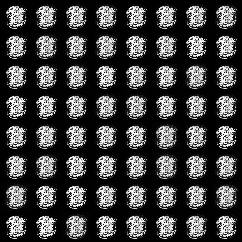



2/51 Sample of generated images


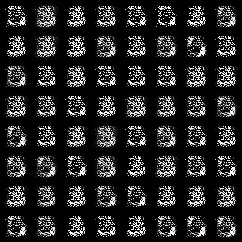



3/51 Sample of generated images


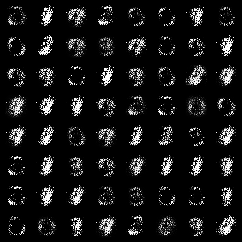



4/51 Sample of generated images


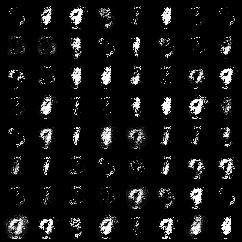



5/51 Sample of generated images


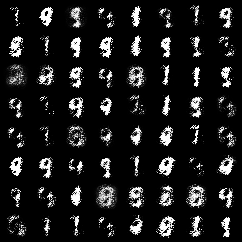



6/51 Sample of generated images


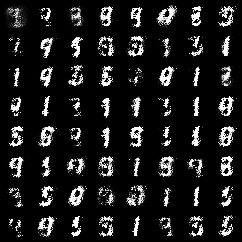



7/51 Sample of generated images


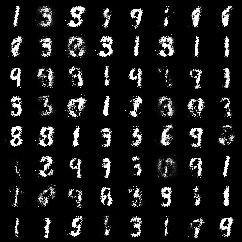



8/51 Sample of generated images


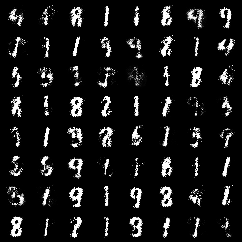



9/51 Sample of generated images


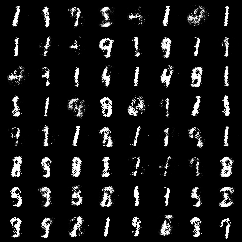



10/51 Sample of generated images


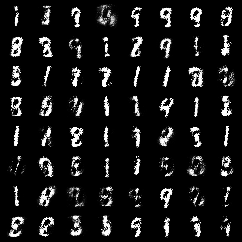



11/51 Sample of generated images


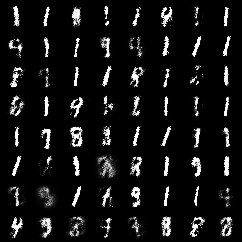



12/51 Sample of generated images


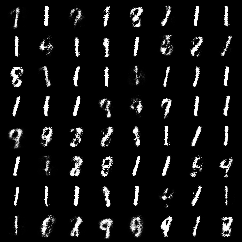



13/51 Sample of generated images


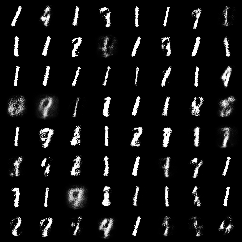



14/51 Sample of generated images


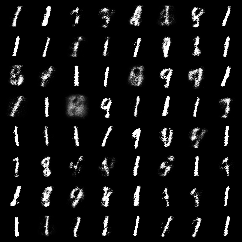



15/51 Sample of generated images


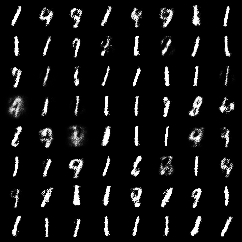



16/51 Sample of generated images


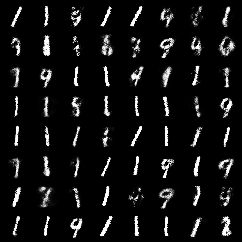



17/51 Sample of generated images


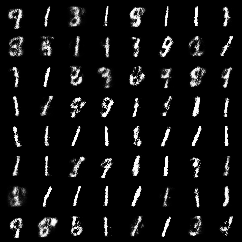



18/51 Sample of generated images


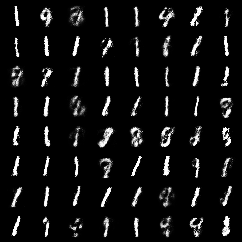



19/51 Sample of generated images


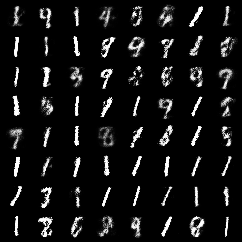



20/51 Sample of generated images


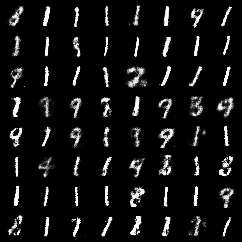



21/51 Sample of generated images


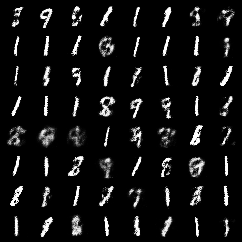



22/51 Sample of generated images


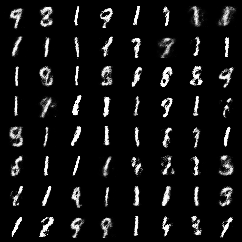



23/51 Sample of generated images


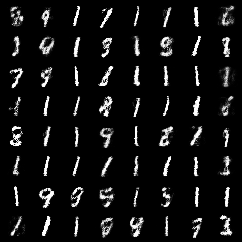



24/51 Sample of generated images


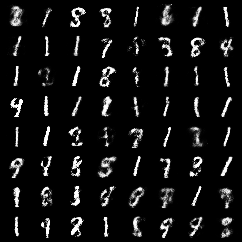



25/51 Sample of generated images


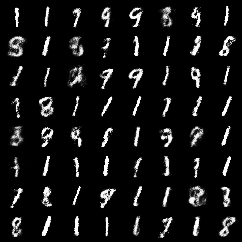



26/51 Sample of generated images


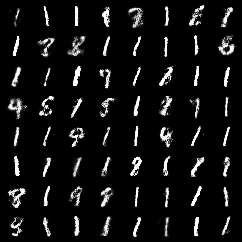



27/51 Sample of generated images


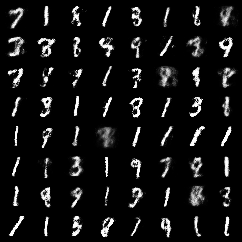



28/51 Sample of generated images


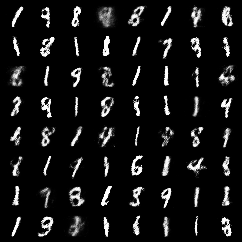



29/51 Sample of generated images


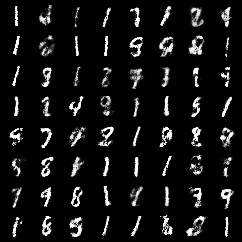



30/51 Sample of generated images


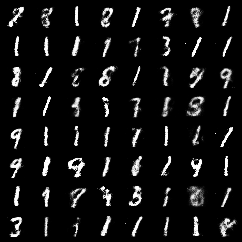



31/51 Sample of generated images


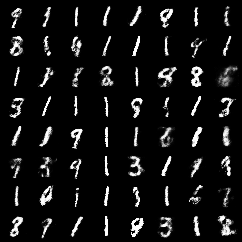



32/51 Sample of generated images


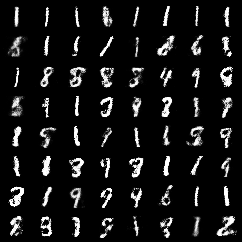



33/51 Sample of generated images


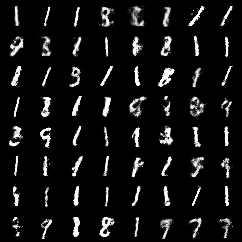



34/51 Sample of generated images


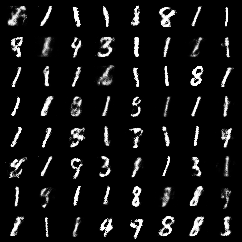



35/51 Sample of generated images


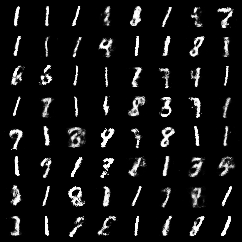



36/51 Sample of generated images


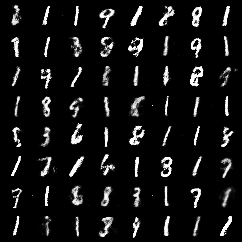



37/51 Sample of generated images


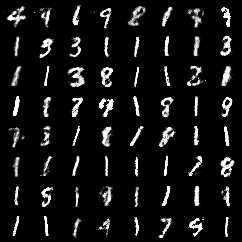



38/51 Sample of generated images


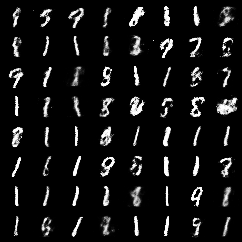



39/51 Sample of generated images


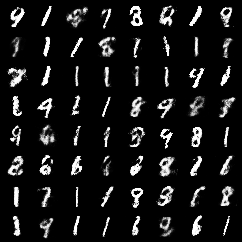



40/51 Sample of generated images


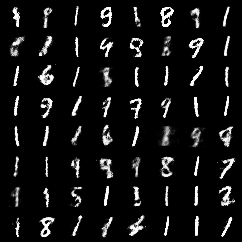



41/51 Sample of generated images


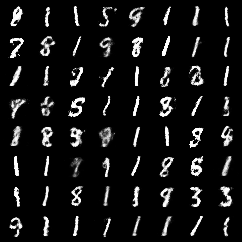



42/51 Sample of generated images


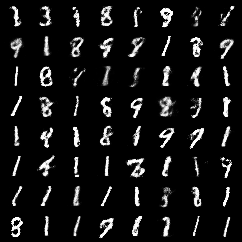



43/51 Sample of generated images


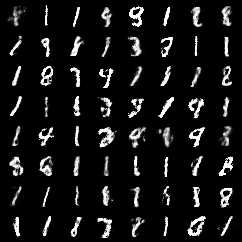



44/51 Sample of generated images


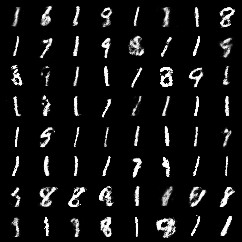



45/51 Sample of generated images


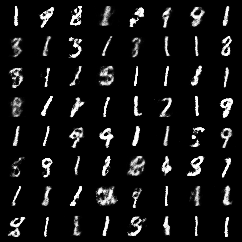



46/51 Sample of generated images


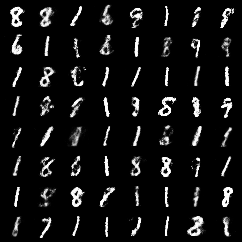



47/51 Sample of generated images


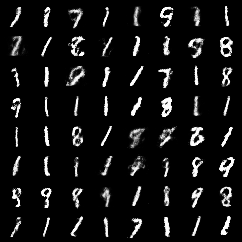



48/51 Sample of generated images


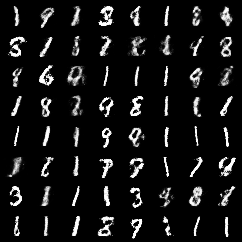



49/51 Sample of generated images


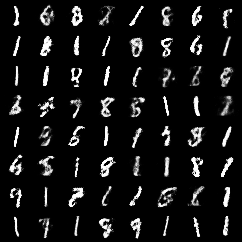



50/51 Sample of generated images


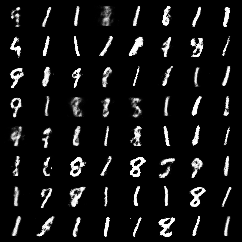

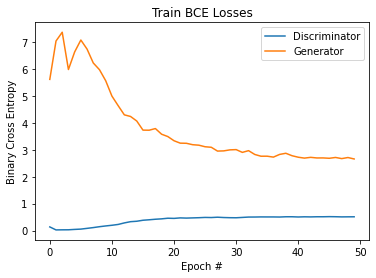

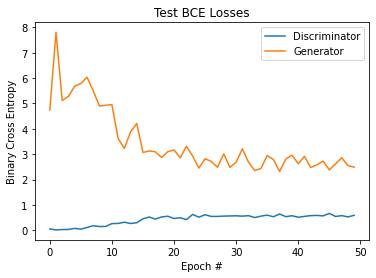

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_adam_sample.png')
            display(Image('results/final_adam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(discriminator_average_train_losses, 'adam_gan_d_large_lr_train.pt')
torch.save(generator_average_train_losses, 'adam_gan_g_large_lr_train.pt')
torch.save(discriminator_average_test_losses, 'adam_gan_d_large_lr_test.pt')
torch.save(generator_average_test_losses, 'adam_gan_g_large_lr_test.pt')

In [ ]:
path_list = ['adam_gan_d_large_lr_train.pt',
             'adam_gan_g_large_lr_train.pt',
             'adam_gan_d_large_lr_test.pt',
             'adam_gan_g_large_lr_test.pt',
             'results/final_adam_sample.png']
for path in path_list:
    files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/51 Sample of generated images


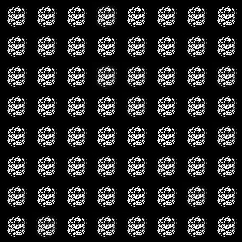



2/51 Sample of generated images


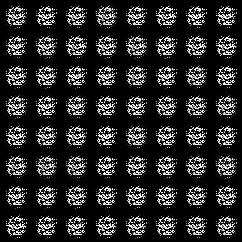



3/51 Sample of generated images


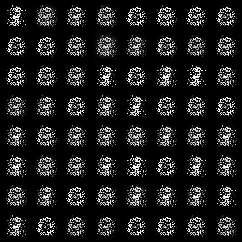



4/51 Sample of generated images


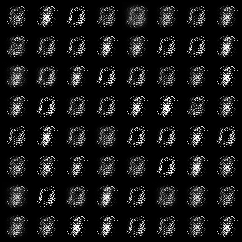



5/51 Sample of generated images


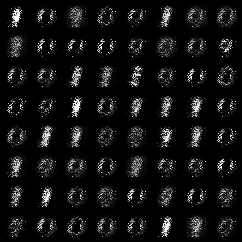



6/51 Sample of generated images


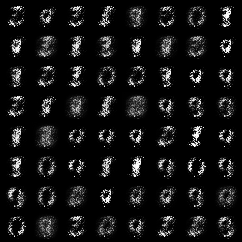



7/51 Sample of generated images


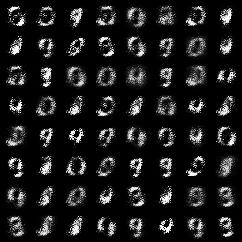



8/51 Sample of generated images


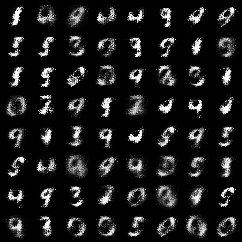



9/51 Sample of generated images


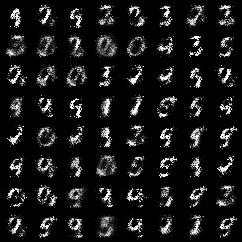



10/51 Sample of generated images


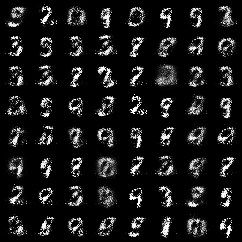



11/51 Sample of generated images


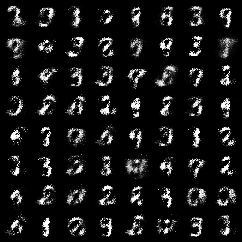



12/51 Sample of generated images


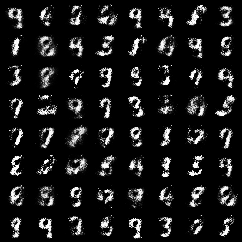



13/51 Sample of generated images


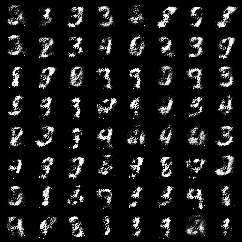



14/51 Sample of generated images


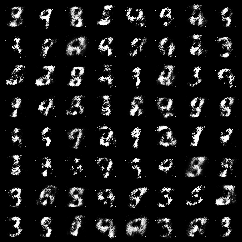



15/51 Sample of generated images


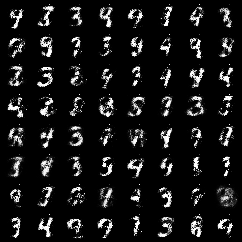



16/51 Sample of generated images


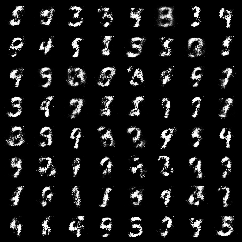



17/51 Sample of generated images


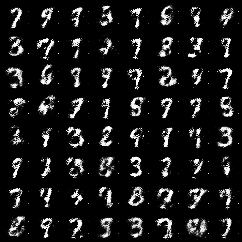



18/51 Sample of generated images


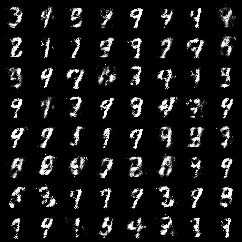



19/51 Sample of generated images


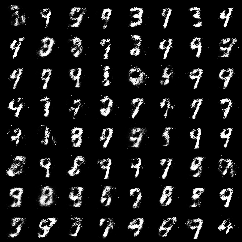



20/51 Sample of generated images


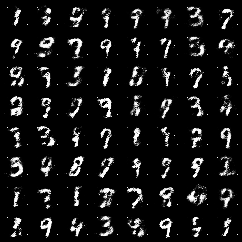



21/51 Sample of generated images


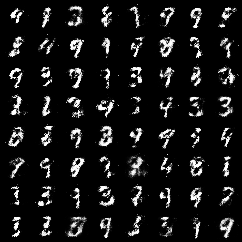



22/51 Sample of generated images


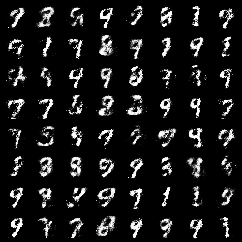



23/51 Sample of generated images


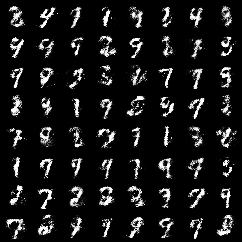



24/51 Sample of generated images


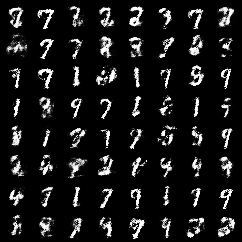



25/51 Sample of generated images


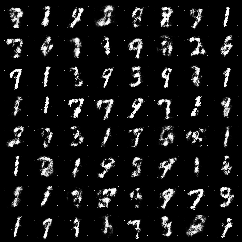



26/51 Sample of generated images


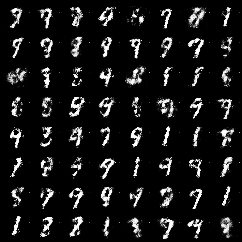



27/51 Sample of generated images


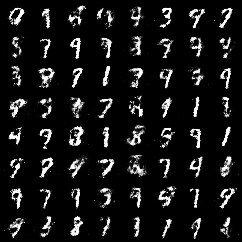



28/51 Sample of generated images


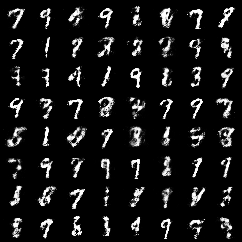



29/51 Sample of generated images


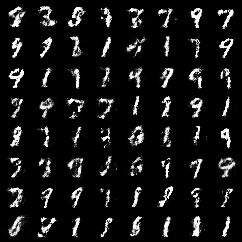



30/51 Sample of generated images


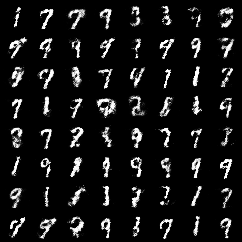



31/51 Sample of generated images


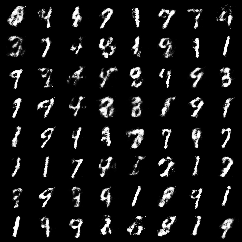



32/51 Sample of generated images


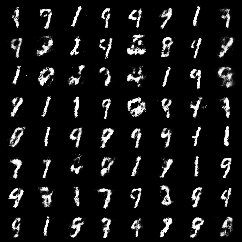



33/51 Sample of generated images


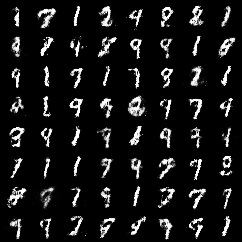



34/51 Sample of generated images


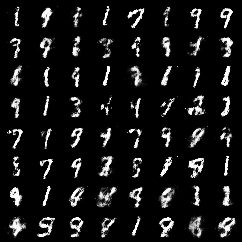



35/51 Sample of generated images


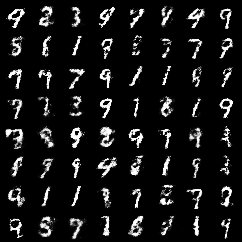



36/51 Sample of generated images


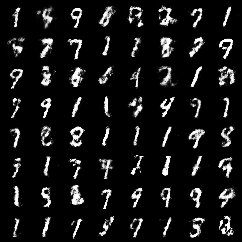



37/51 Sample of generated images


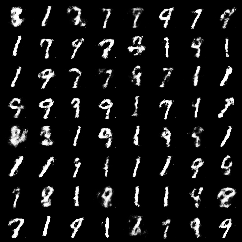



38/51 Sample of generated images


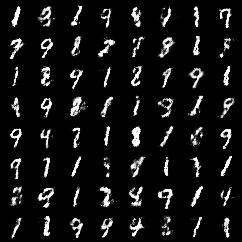



39/51 Sample of generated images


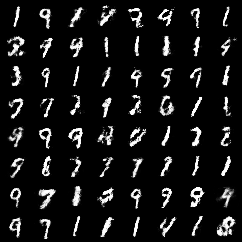



40/51 Sample of generated images


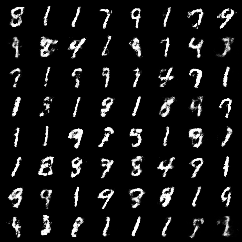



41/51 Sample of generated images


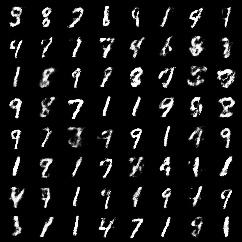



42/51 Sample of generated images


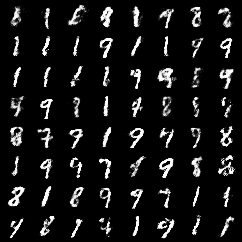



43/51 Sample of generated images


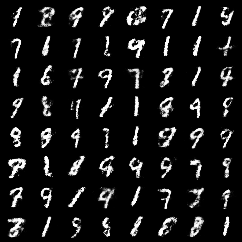



44/51 Sample of generated images


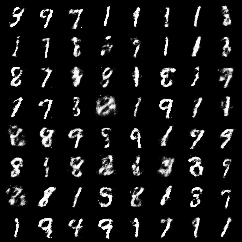



45/51 Sample of generated images


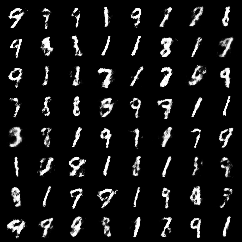



46/51 Sample of generated images


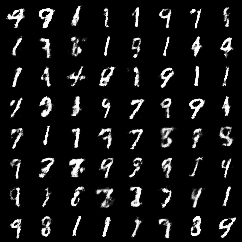



47/51 Sample of generated images


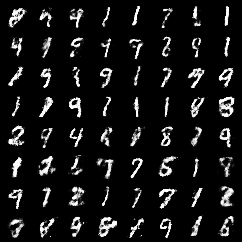



48/51 Sample of generated images


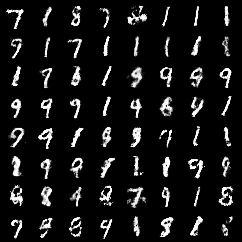



49/51 Sample of generated images


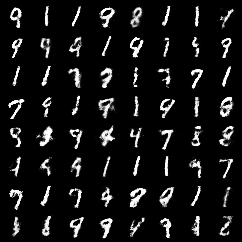



50/51 Sample of generated images


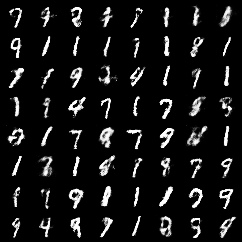

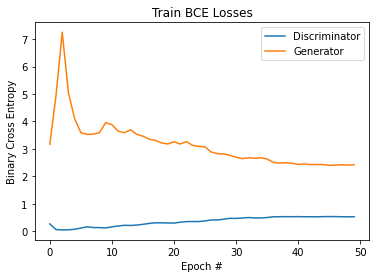

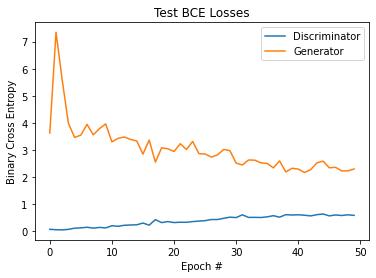

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=3e-4)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=3e-4)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs + 1))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_adam_sample.png')
            display(Image('results/final_adam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(discriminator_average_train_losses, 'adam_gan_d_medium_lr_train.pt')
torch.save(generator_average_train_losses, 'adam_gan_g_medium_lr_train.pt')
torch.save(discriminator_average_test_losses, 'adam_gan_d_medium_lr_test.pt')
torch.save(generator_average_test_losses, 'adam_gan_g_medium_lr_test.pt')

In [ ]:
path_list = ['adam_gan_d_medium_lr_train.pt',
             'adam_gan_g_medium_lr_train.pt',
             'adam_gan_d_medium_lr_test.pt',
             'adam_gan_g_medium_lr_test.pt',
             'results/final_adam_sample.png']
for path in path_list:
    files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/51 Sample of generated images


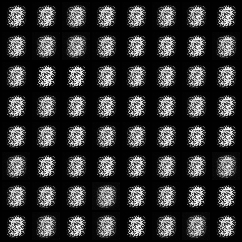



2/51 Sample of generated images


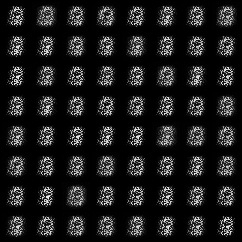



3/51 Sample of generated images


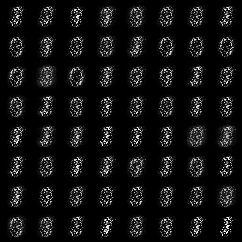



4/51 Sample of generated images


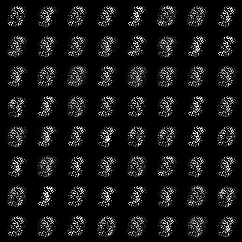



5/51 Sample of generated images


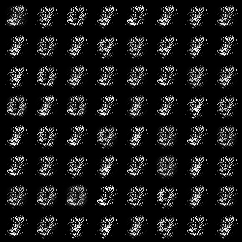



6/51 Sample of generated images


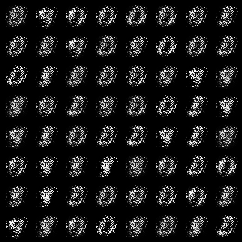



7/51 Sample of generated images


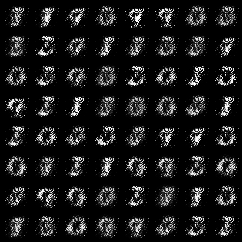



8/51 Sample of generated images


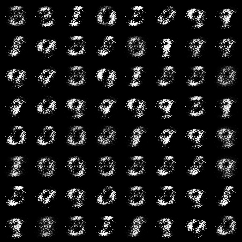



9/51 Sample of generated images


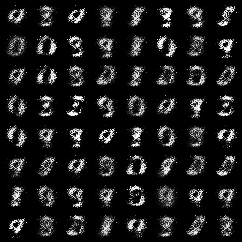



10/51 Sample of generated images


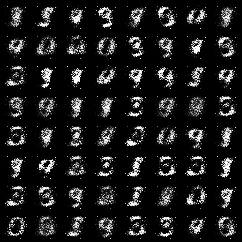



11/51 Sample of generated images


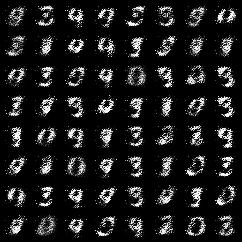



12/51 Sample of generated images


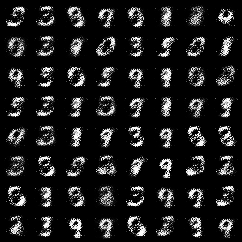



13/51 Sample of generated images


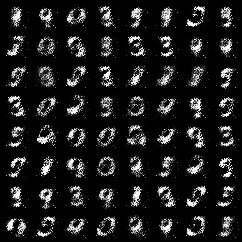



14/51 Sample of generated images


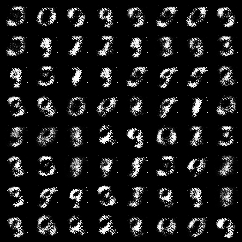



15/51 Sample of generated images


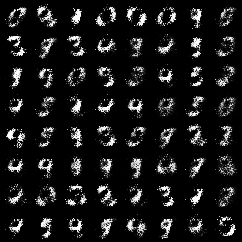



16/51 Sample of generated images


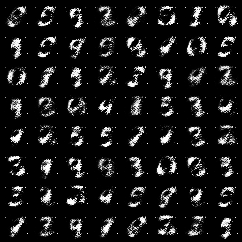



17/51 Sample of generated images


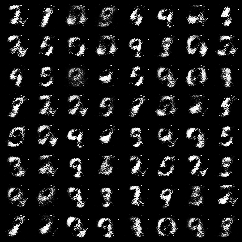



18/51 Sample of generated images


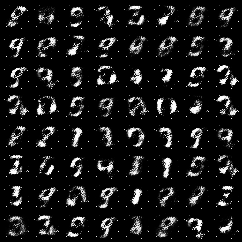



19/51 Sample of generated images


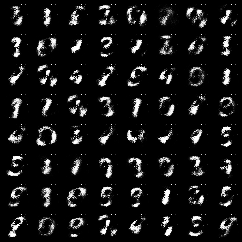



20/51 Sample of generated images


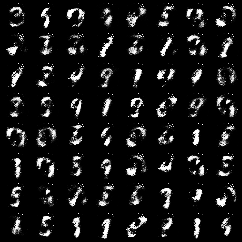



21/51 Sample of generated images


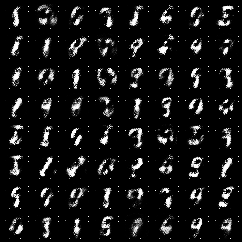



22/51 Sample of generated images


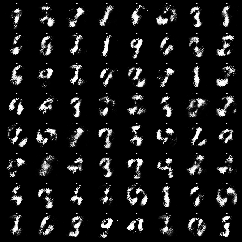



23/51 Sample of generated images


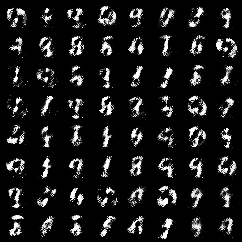



24/51 Sample of generated images


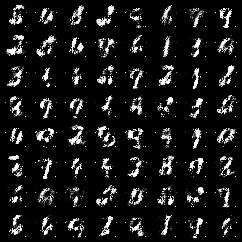



25/51 Sample of generated images


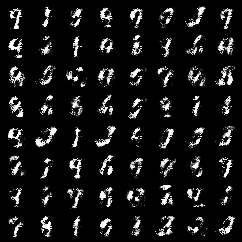



26/51 Sample of generated images


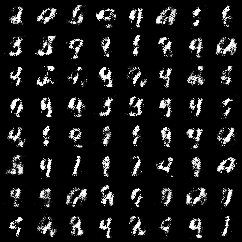



27/51 Sample of generated images


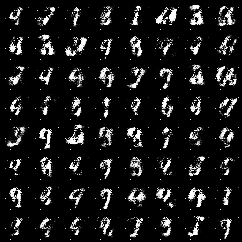



28/51 Sample of generated images


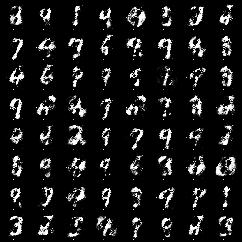



29/51 Sample of generated images


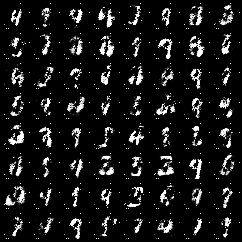



30/51 Sample of generated images


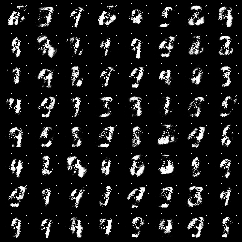



31/51 Sample of generated images


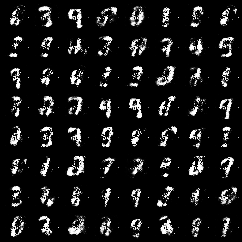



32/51 Sample of generated images


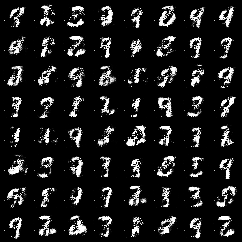



33/51 Sample of generated images


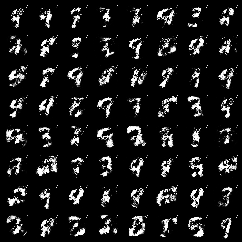



34/51 Sample of generated images


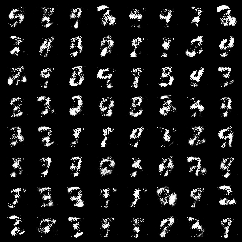



35/51 Sample of generated images


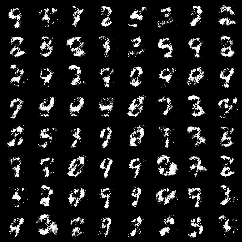



36/51 Sample of generated images


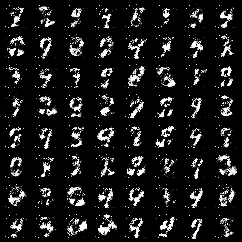



37/51 Sample of generated images


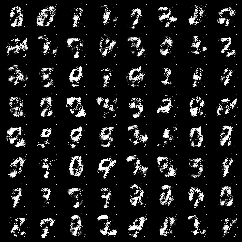



38/51 Sample of generated images


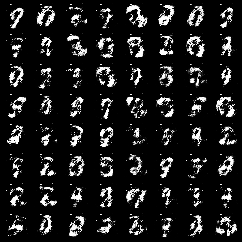



39/51 Sample of generated images


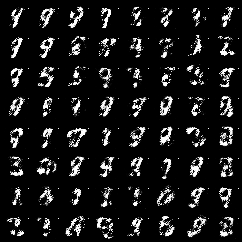



40/51 Sample of generated images


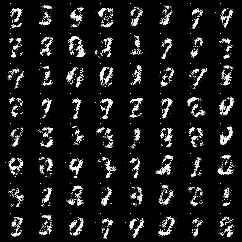



41/51 Sample of generated images


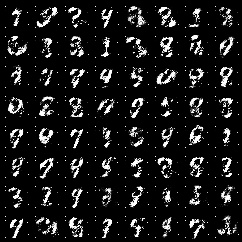



42/51 Sample of generated images


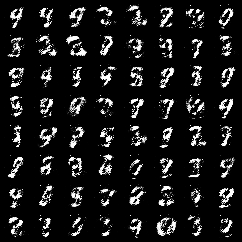



43/51 Sample of generated images


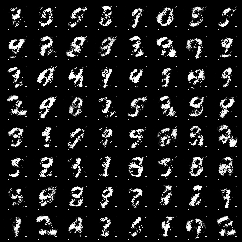



44/51 Sample of generated images


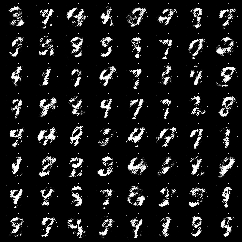



45/51 Sample of generated images


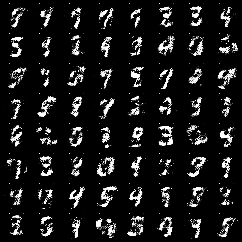



46/51 Sample of generated images


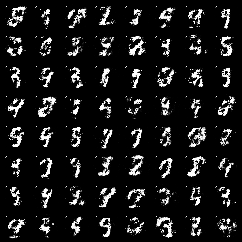



47/51 Sample of generated images


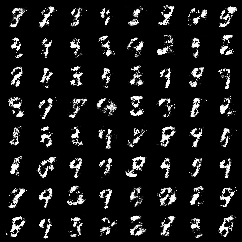



48/51 Sample of generated images


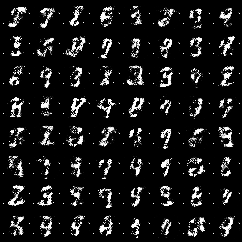



49/51 Sample of generated images


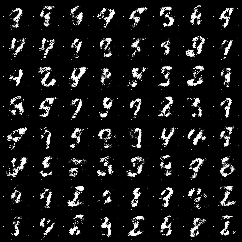



50/51 Sample of generated images


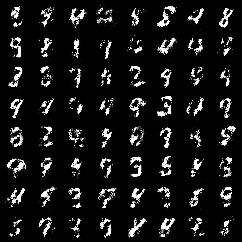

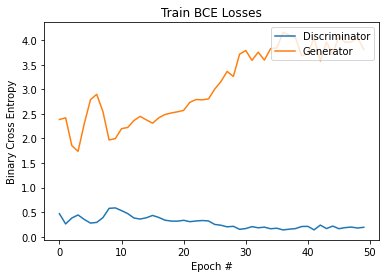

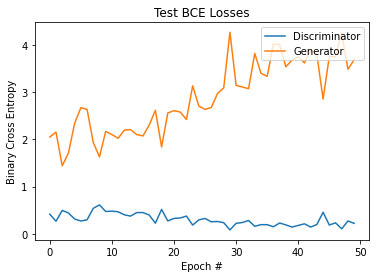

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-4)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-4)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs + 1))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_adam_sample.png')
            display(Image('results/final_adam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(discriminator_average_train_losses, 'adam_gan_d_small_lr_train.pt')
torch.save(generator_average_train_losses, 'adam_gan_g_small_lr_train.pt')
torch.save(discriminator_average_test_losses, 'adam_gan_d_small_lr_test.pt')
torch.save(generator_average_test_losses, 'adam_gan_g_small_lr_test.pt')

In [ ]:
path_list = ['adam_gan_d_small_lr_train.pt',
             'adam_gan_g_small_lr_train.pt',
             'adam_gan_d_small_lr_test.pt',
             'adam_gan_g_small_lr_test.pt',
             'results/final_adam_sample.png']
for path in path_list:
    files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>